# Categorizing Ingredients Using Machine Learning and NLP Methods
#### CS-E4870 - Research Project in Machine Learning and Data Science

#### Topic
To explore different ways to categorize/cluster noisy text to groups and find out which one of them works best for categorizing ingredients from receipts. The dataset for this experiment would be my own purchases from the last 12 month, including ~500 distinct ingredients. The name of the ingredient usually consists of 1-4 words, for example “Apple juice 1l” and does not follow any commonly used naming rule. The idea would be to preprocess the data by removing unnecessary text (“1l”) and trying to use methods to cluster the ingredient under correct category: “Apple juice 1l” is more likely a juice than a fruit.

#### Approaches
Following approaches are explored:
* Machine Learning:
    * Decision Tree
    * Random Forest
    * K-means++
* Natural Language Processing:
    * Turku NLP pretrained model
    * Gensim Word2Vec
    
#### Problems encountered
* Defining class names to K-means++ clusters
* Finding proper training set for Gensim Word2Vec model

In [1]:
import datahandling
import models

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

C:\Users\kristela\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## 1. Dataset

In [2]:
# Get data from file
df_data = datahandling.load()

#Select needed columns
feature_cols = ['Rasvaa','Hiilihydraattia','Proteiinia','Ravintokuitua','Energiaa','Suola','Sokeria']
label_col = ['group1']
name_col = ['Nimi']
cols = name_col[:]
cols.extend(label_col)
cols.extend(feature_cols)

df_data = df_data[cols]
df_data = df_data.replace('Hedelmät ja vihannekset:1', 'Hedelmät ja vihannekset:100') # Needed for K-means++
df_data.head()

,Nimi,group1,Rasvaa,Hiilihydraattia,Proteiinia,Ravintokuitua,Energiaa,Suola,Sokeria
0,maustettu rahka 200g irish cream,Maito:351,7.0,16.0,7.2,0.0,652.0,0.08,0.0
1,lempi 200g 28% lton crème fraiche,Maito:351,28.0,2.5,2.3,0.0,1132.0,0.10,0.0
2,valio hedtarha luomumustmehu 1l,Juomat:994,0.0,9.2,0.0,0.0,158.0,0.00,0.0
3,maustettu rahka 200g appels lton,Maito:351,7.0,16.0,7.2,0.0,650.0,0.10,0.0
4,alpro 400g mango pbay soijavalmiste,Maito:351,2.0,5.8,3.7,1.0,255.0,0.22,0.0


In [3]:
# Drop all data which includes cucumber (=kurkku), cucumber will be used later to test ingredients that are not in the dataset
df_data[df_data['Nimi'].str.contains('kurkku')]

,Nimi,group1,Rasvaa,Hiilihydraattia,Proteiinia,Ravintokuitua,Energiaa,Suola,Sokeria
34,kurkku suomi,Hedelmät ja vihannekset:100,0.0641,1.4,0.56,0.7,46.0,0.01,0.0
181,eucamenthol 200g kurkkukaramelli,"Makeiset, jäätelöt ja naposteltavat:1144",0.5000,96.0,0.50,0.0,1622.0,0.11,0.0


In [4]:
df_data = df_data.drop([34])
df_data[df_data['Nimi'].str.contains('kurkku')]

,Nimi,group1,Rasvaa,Hiilihydraattia,Proteiinia,Ravintokuitua,Energiaa,Suola,Sokeria
181,eucamenthol 200g kurkkukaramelli,"Makeiset, jäätelöt ja naposteltavat:1144",0.5,96.0,0.5,0.0,1622.0,0.11,0.0


In [5]:
classes_name = [c.split(':')[0] for c in df_data.group1.unique()] 
classes_id = [int(c.split(':')[1]) for c in df_data.group1.unique()] 

print("Group1 labels:\n{}\n".format(classes_name))
print("Group1 ids:\n{}".format(classes_id))

Group1 labels:
['Maito', 'Juomat', 'Juustot', 'Valmisruoka', 'Hedelmät ja vihannekset', 'Leipä', 'Liha', 'Lemmikit', 'Makeiset, jäätelöt ja naposteltavat', 'Kuivatuotteet', 'Leivonta ja maustaminen', 'Munat', 'Pakasteet', 'Rasvat ja öljyt', 'Kala', 'Terveystuotteet']

Group1 ids:
[351, 994, 417, 497, 100, 701, 80, 1337, 1144, 895, 807, 1784, 1075, 476, 262, 12129]


## 2. Machine Learning Methods

In [6]:
# Features and numeric labels
X = df_data[feature_cols] # Features
y =  pd.DataFrame([int(c.split(':')[1]) for c in df_data.group1])  # Target label 

# Models
ml_models = [{'name': 'Decision Tree', 'class': models.DecisionTreeModel, 'trained_model': None, 
              'training_accuracy':0, 'validation_accuracy':0, 'uses_all_features':True, 'classes_order':[],
              'y_train':[], 'y_train_pred':[], 'y_validation':[], 'y_validation_pred':[]},
             {'name': 'Random Forest', 'class': models.RandomForestModel, 'trained_model': None,
              'training_accuracy':0, 'validation_accuracy':0, 'uses_all_features':True, 'classes_order':[],
              'y_train':[], 'y_train_pred':[], 'y_validation':[], 'y_validation_pred':[]},
             {'name': 'K-means', 'class': models.KmeansModel, 'trained_model': None,
              'training_accuracy':0, 'validation_accuracy':0, 'uses_all_features':True, 'classes_order':[],
              'y_train':[], 'y_train_pred':[], 'y_validation':[], 'y_validation_pred':[]},
            ]

### 2.1 Feature Selection

Feature importance


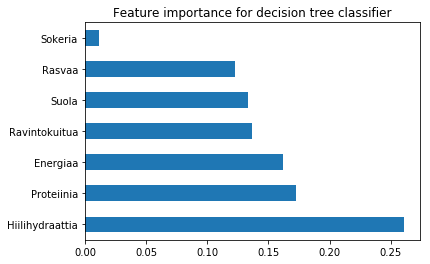

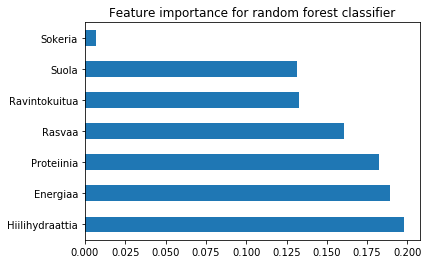

Feature correlation (0=Group1)


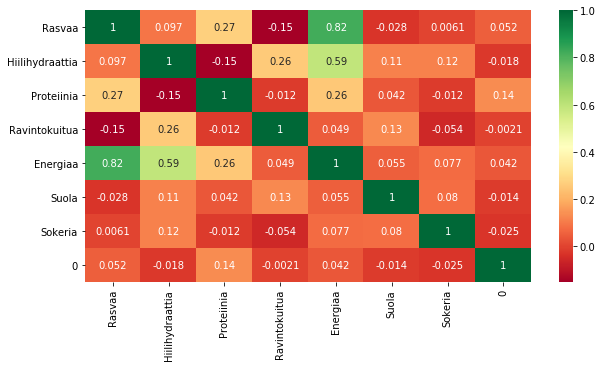

In [7]:
# Feature importance gives you a score for each feature of your data, the higher the score more important 
# or relevant is the feature towards your output variable.
def exploreFeautreImportance():
    clf = DecisionTreeClassifier().fit(X,y)
    feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
    feat_importances.nlargest(len(X.columns)).plot(kind='barh')
    plt.title("Feature importance for decision tree classifier")
    plt.show()
    
    clf = RandomForestClassifier(n_estimators=100).fit(X,y.squeeze())
    feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
    feat_importances.nlargest(len(X.columns)).plot(kind='barh')
    plt.title("Feature importance for random forest classifier")
    plt.show()

# Correlation states how the features are related to each other or the target variable.
def exploreFeaturesUsingCorrelationMatrix():
    data = pd.concat([X, y], axis=1, sort=False)
    corrmat = data.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(10,5))
    #plot heat map
    sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")
    plt.show()

print("Feature importance")
exploreFeautreImportance()
print("Feature correlation (0=Group1)")
exploreFeaturesUsingCorrelationMatrix()

In [8]:
feature_cols_top3 = ['Hiilihydraattia','Proteiinia','Energiaa']
print("Based on the graphs above the top3 features are: ", feature_cols_top3)

Based on the graphs above the top3 features are:  ['Hiilihydraattia', 'Proteiinia', 'Energiaa']


### 2.2 Train

In [9]:
def update_selected_ml_model(model, result, use_all_features):
    model['trained_model'] = result['model']
    model['training_accuracy'] = result['train score']
    model['validation_accuracy'] = result['test score']
    model['uses_all_features'] = use_all_features
    model['y_train'] = result['train real'][:]
    model['y_train_pred'] = result['train pred'][:]
    model['y_validation'] = result['test real'][:]
    model['y_validation_pred'] = result['test pred'][:]
    if 'classes_order' in result:
        model['classes_order'] = result['classes_order'][:]

In [10]:
# Use K-cross validation for training each model
kf = KFold(n_splits=5, shuffle=False)
for train_index, test_index in kf.split(X):
    y_train, y_test = y.to_numpy()[train_index], y.to_numpy()[test_index]
    #y_test = pd.DataFrame(y_test)
    
    # Train model using all features
    X_train, X_test = X.to_numpy()[train_index], X.to_numpy()[test_index]
    for m in ml_models:
        if m['name']=='K-means':
            result = m['class'](X_train, y_train, X_test, y_test, classes_id)
        else:
            result = m['class'](X_train, y_train, X_test, y_test)
        # Update so far best model
        mean_result = (result['train score']*0.8+result['test score']*0.2)/2
        mean_current = (m['training_accuracy']*0.8+m['validation_accuracy']*0.2)/2
        if mean_result > mean_current:
            update_selected_ml_model(m, result, True)
            
    # Train model using 3 features
    X_train, X_test = X[feature_cols_top3].to_numpy()[train_index], X[feature_cols_top3].to_numpy()[test_index]
    for m in ml_models:
        if m['name']=='K-means':
            result = m['class'](X_train, y_train, X_test, y_test, classes_id)
        else:
            result = m['class'](X_train, y_train, X_test, y_test)
        # Update so far best model
        mean_result = (result['train score']+result['test score'])/2
        mean_current = (m['training_accuracy']+m['validation_accuracy'])/2
        if mean_result > mean_current:
            update_selected_ml_model(m, result, False)

### 2.3 Evaluate

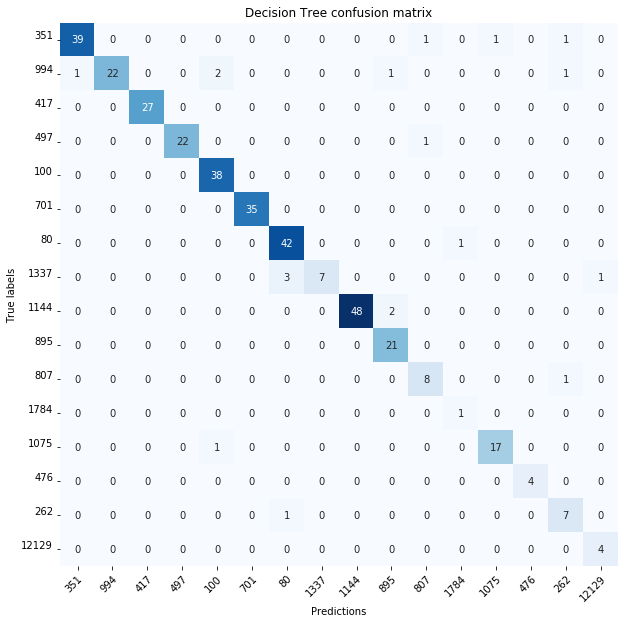

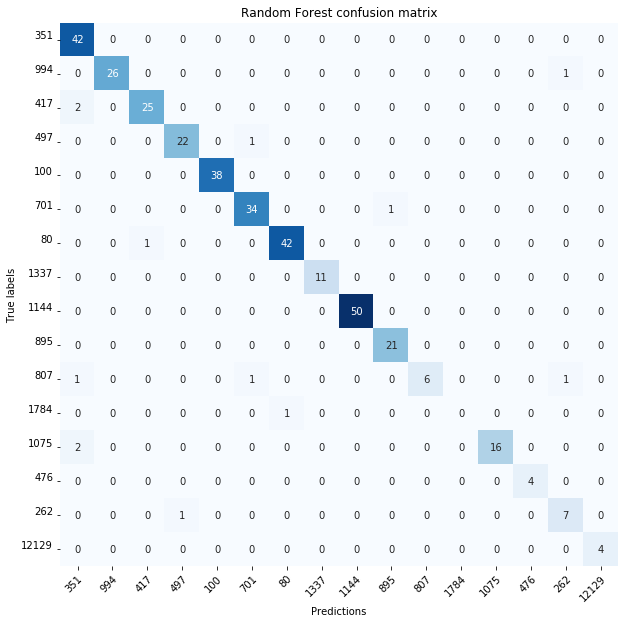

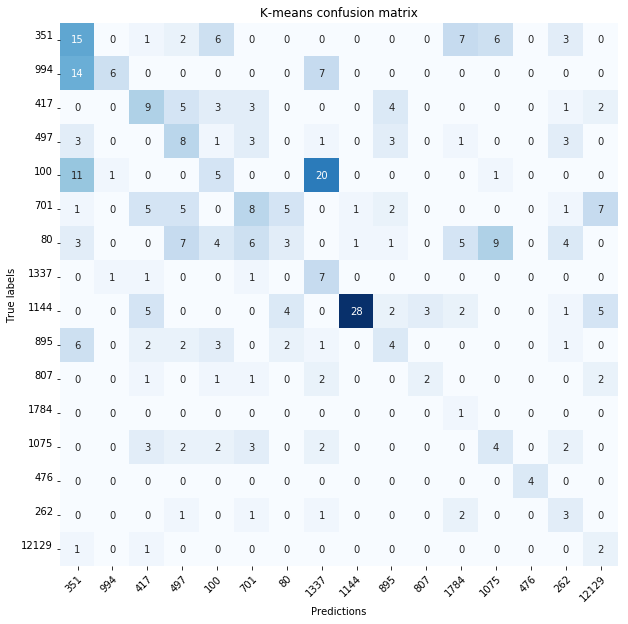

In [11]:
for m in ml_models:
    m_real = list(m['y_train'].flatten()[:])
    m_real.extend(m['y_validation'].flatten())
    m_pred = list(m['y_train_pred'].flatten()[:])
    m_pred.extend(m['y_validation_pred'].flatten())

    models._create_confusion_matrix(pd.DataFrame(m_real), m_pred, m['name'], classes_id)

In [12]:
for m in ml_models:
    print("Model: {}, Features: {}, Training score: {:.2f}, Validation score {:.2f}".format(m['name'], 
                    'All' if m['uses_all_features'] else 'Top-3',
                    m['training_accuracy'], m['validation_accuracy']))
    
print("")
for m in ml_models:
    if m['uses_all_features']:
        all_data = X.to_numpy()
    else:
        all_data = X[feature_cols_top3].to_numpy()
    if m['name']=='K-means':
        y_pred = m['trained_model'].predict(all_data)
        y_pred = models._kmeans_convert_clusters_to_classes(y.to_numpy(), y_pred, classes_id, m['classes_order'])['pred']
    else:
        y_pred = m['trained_model'].predict(all_data)
    print("Model: {}, Trained with K-Cross Validator, Full data score: {:.2f}".format(m['name'],
            accuracy_score(y_pred,y)))

Model: Decision Tree, Features: Top-3, Training score: 0.99, Validation score 0.76
Model: Random Forest, Features: All, Training score: 1.00, Validation score 0.84
Model: K-means, Features: Top-3, Training score: 0.25, Validation score 0.50

Model: Decision Tree, Trained with K-Cross Validator, Full data score: 0.95
Model: Random Forest, Trained with K-Cross Validator, Full data score: 0.96
Model: K-means, Trained with K-Cross Validator, Full data score: 0.24


## 3. Natural Language Processing Methods

In [13]:
# Features and labels
X = df_data[name_col] # Feature: name of the ingredient
y =  pd.DataFrame([int(c.split(':')[1]) for c in df_data.group1])  # Target label 
y.columns = ['group1']

# Models
nlp_models = [{'name': 'LWVLIB', 'class': models.NLPModel(classes_id,classes_name), 'trained_model': None, 
              'training_accuracy':0, 'validation_accuracy':0, 'pretrained':True,
              'y_train':[], 'y_train_pred':[], 'y_validation':[], 'y_validation_pred':[]},
             {'name': 'Gensim Word2Vec', 'class': models.NLPModel(classes_id,classes_name), 'trained_model': None,
              'training_accuracy':0, 'validation_accuracy':0, 'pretrained':False,
              'y_train':[], 'y_train_pred':[], 'y_validation':[], 'y_validation_pred':[]}]
nlp_models[0]['class'].load('lwvlib') #Load pretrained model once

### 3.1 Train

In [14]:
# Use K-cross validation for training each model
kf = KFold(n_splits=5, shuffle=False)
all_data=df_data[['Nimi','group1']].to_numpy()

for train_index, test_index in kf.split(X):   
    train_data =pd.DataFrame(all_data[train_index]) 
    train_data.columns = ['Nimi','group1']
    test_data = pd.DataFrame(all_data[test_index])
    test_data.columns = ['Nimi','group1']

    for m in nlp_models:
        if not m['pretrained']:
            m['class'].train(train_data)

        train_result = m['class'].predict(train_data)
        test_result = m['class'].predict(test_data)
        
        # Update so far best model
        mean_result = (train_result['score']*0.8+test_result['score']*0.2)/2
        mean_current = (m['training_accuracy']*0.8+m['validation_accuracy']*0.2)/2
        if mean_result > mean_current:
            if not m['pretrained']:
                m['trained_model'] = copy.deepcopy(m['class'])
            m['training_accuracy'] = train_result['score']
            m['validation_accuracy'] = test_result['score']
            m['y_train'] = train_result['real'][:]
            m['y_train_pred'] = train_result['pred'][:]
            m['y_validation'] = test_result['real'].to_numpy()[:]
            m['y_validation_pred'] = test_result['pred'][:]

Let's train a NLP model with all the data and compare its results to a model which was selected above.

In [15]:
train_data = df_data[['Nimi','group1']]
nlp_models[1]['class'].train(train_data)
print("Trained on whole data, score: ", nlp_models[1]['class'].predict(train_data)['score'])
print("Trained with K-Cross Validator, score: ", nlp_models[1]['trained_model'].predict(train_data)['score'])

Trained on whole data, score:  0.6620498614958449
Trained with K-Cross Validator, score:  0.6509695290858726


Model selected from K-Cross Validator might perform slightly better.

### 3.2 Evaluate

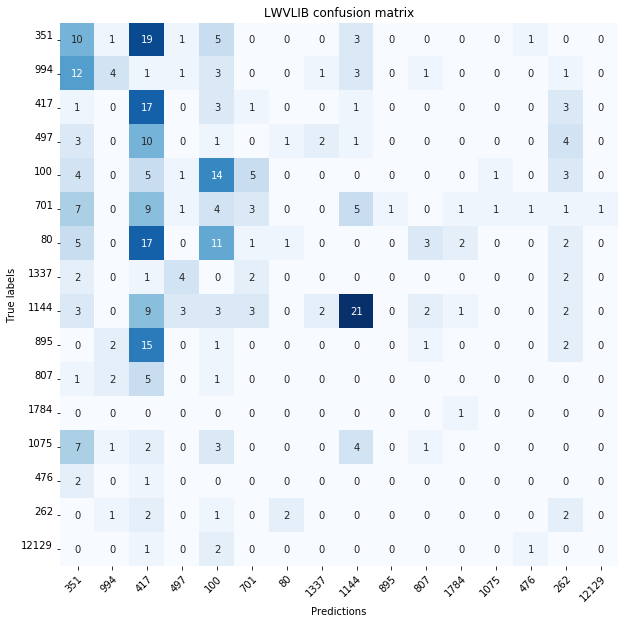

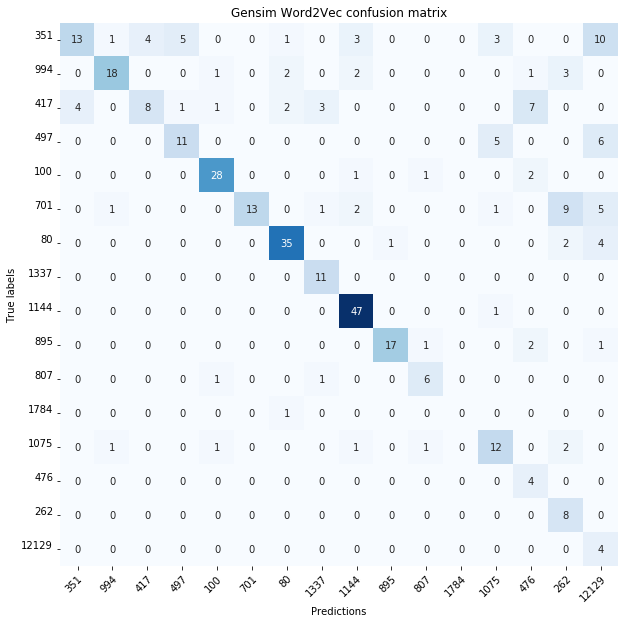

In [16]:
for m in nlp_models:
    m_real = list(m['y_train'][:])
    m_real.extend(m['y_validation'].flatten())
    m_pred = list(m['y_train_pred'][:])
    m_pred.extend(m['y_validation_pred'])

    models._create_confusion_matrix(pd.DataFrame(m_real), m_pred, m['name'], classes_id)

In [17]:
for m in nlp_models:
    print("Model: {}, Training score: {:.2f}, Validation score {:.2f}".format(m['name'], 
                    m['training_accuracy'], m['validation_accuracy']))
    
print("")
for m in nlp_models:
    all_data = df_data[['Nimi','group1']]
    
    if m['trained_model']:
        score = m['trained_model'].predict(all_data)['score']
        print("Model: {}, Trained with K-Cross Validator, full data score: {:.2f}".format(m['name'],score))
    else: 
        score = m['class'].predict(all_data)['score']
        print("Model: {}, Pretrained, full data score: {:.2f}".format(m['name'],score))

Model: LWVLIB, Training score: 0.22, Validation score 0.14
Model: Gensim Word2Vec, Training score: 0.73, Validation score 0.36

Model: LWVLIB, Pretrained, full data score: 0.20
Model: Gensim Word2Vec, Trained with K-Cross Validator, full data score: 0.65


## 4. Predict

In [18]:
group1 = df_data.group1.unique()
print(group1)

['Maito:351' 'Juomat:994' 'Juustot:417' 'Valmisruoka:497'
 'Hedelmät ja vihannekset:100' 'Leipä:701' 'Liha:80' 'Lemmikit:1337'
 'Makeiset, jäätelöt ja naposteltavat:1144' 'Kuivatuotteet:895'
 'Leivonta ja maustaminen:807' 'Munat:1784' 'Pakasteet:1075'
 'Rasvat ja öljyt:476' 'Kala:262' 'Terveystuotteet:12129']


In [19]:
predict_data = pd.DataFrame([
    # Nimi,      group1,    Rasvaa, Hiilihydraattia, Proteiinia, Ravintokuitua, Energiaa, Suola, Sokeria
    
    ## Similar ingredients
    ['tomaatti', group1[4], 0.1614, 3.45,            0.56,       1.4,           95,       0,     0 ], #tomato
    ['paprika',  group1[4], 0.21,   2.5,             0.94,       1.9,           89,       0,     0 ], #paprika
    
    ## Ingredients that were not in the training dataset
    ['kurkku',   group1[4], 0.0641, 1.4,             0.56,       0.7,           46,       0.01,  0 ], #cucumber
    ['retiisi', group1[4], 0.0902,  1.95,            1.44,       1.6,           74,       0.04,  0 ]  #radish
    
], columns=cols)

predict_data.head()

,Nimi,group1,Rasvaa,Hiilihydraattia,Proteiinia,Ravintokuitua,Energiaa,Suola,Sokeria
0,tomaatti,Hedelmät ja vihannekset:100,0.1614,3.45,0.56,1.4,95,0.00,0
1,paprika,Hedelmät ja vihannekset:100,0.2100,2.50,0.94,1.9,89,0.00,0
2,kurkku,Hedelmät ja vihannekset:100,0.0641,1.40,0.56,0.7,46,0.01,0
3,retiisi,Hedelmät ja vihannekset:100,0.0902,1.95,1.44,1.6,74,0.04,0


In [25]:
predict_summary = predict_data[['Nimi', 'group1']]

### Machine Learning Methods ###
X = predict_data[feature_cols] # Features: nutrients of the ingredient
y =  pd.DataFrame([int(c.split(':')[1]) for c in predict_data.group1])  # Target label 
y.columns = ['group1']
for m in ml_models:
    if m['uses_all_features']:
        all_data = X[feature_cols].to_numpy()
    else:
        all_data = X[feature_cols_top3].to_numpy()
        
    if m['name']=='K-means':
        y_pred = m['trained_model'].predict(all_data)
        y_pred = models._kmeans_convert_clusters_to_classes(y.to_numpy(), y_pred, classes_id, m['classes_order'])['pred']
    else:
        y_pred = m['trained_model'].predict(all_data)
        
    predict_summary.insert(len(predict_summary.columns), m['name'], pd.Series(y_pred, index=predict_summary.index))

### Natural Language Processing Methods ###
all_data = predict_data[['Nimi','group1']]
for m in nlp_models:
    if m['trained_model']:
        result = m['trained_model'].predict(all_data)
    else: 
        result = m['class'].predict(all_data)
    predict_summary.insert(len(predict_summary.columns), m['name'], pd.Series(result['pred'], index=predict_summary.index))

predict_summary.head()

,Nimi,group1,Decision Tree,Random Forest,K-means,LWVLIB,Gensim Word2Vec
0,tomaatti,Hedelmät ja vihannekset:100,100,100,100,100,100
1,paprika,Hedelmät ja vihannekset:100,100,100,100,100,100
2,kurkku,Hedelmät ja vihannekset:100,100,994,100,351,-1
3,retiisi,Hedelmät ja vihannekset:100,100,100,100,100,-1


## 4. Summary

In [22]:
summary = []

### Machine Learning Methods ###
X = df_data[feature_cols] # Features: nutrients of the ingredient
y =  pd.DataFrame([int(c.split(':')[1]) for c in df_data.group1])  # Target label 
y.columns = ['group1']
for m in ml_models:
    
    if m['uses_all_features']:
        all_data = X[feature_cols].to_numpy()
    else:
        all_data = X[feature_cols_top3].to_numpy()
    
    if m['name']=='K-means':
        y_pred = m['trained_model'].predict(all_data)
        y_pred = models._kmeans_convert_clusters_to_classes(y.to_numpy(), y_pred, classes_id, m['classes_order'])['pred']
    else:
        y_pred = m['trained_model'].predict(all_data)
        
    
    summary.append([m['name'],m['training_accuracy'],m['validation_accuracy'],accuracy_score(y_pred,y)])

### Natural Language Processing Methods ###
all_data = df_data[['Nimi','group1']]
for m in nlp_models:
    if m['trained_model']:
        score = m['trained_model'].predict(all_data)['score']
    else: 
        score = m['class'].predict(all_data)['score']
    
    summary.append([m['name'],m['training_accuracy'],m['validation_accuracy'],score])
        
df_summary = pd.DataFrame(summary)
df_summary.columns = ['Name', 'Training Accuracy', 'Validation Accuracy', 'Prediction Accuracy']
df_summary = df_summary.sort_values(by=['Prediction Accuracy'],ascending=False)
df_summary.head()

,Name,Training Accuracy,Validation Accuracy,Prediction Accuracy
1,Random Forest,0.996528,0.835616,0.963989
0,Decision Tree,0.993080,0.763889,0.947368
4,Gensim Word2Vec,0.725694,0.356164,0.650970
2,K-means,0.252595,0.500000,0.243767
3,LWVLIB,0.218750,0.136986,0.202216
